In [172]:
import numpy as np
import pandas as pd
import sys
import pickle as pkl

import pandas as pd
import pickle as pkl
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
import os
from matplotlib import pyplot as plt

from scipy.special import expit as sigmoid
from PIL import Image

header_data = '../data/'

### Late Fusion - Axial+Coronal+EHR

In [ ]:
df = pd.read_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))
print(len(df))
def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
    
df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())


dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]

In [195]:
## Training

dct_axial = pkl.load(open('Model/Axial/train/train-01/train_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('Model/Coronal/train/train-01/train_predictions.pkl', 'rb'))
dct_baseline = pkl.load(open('Models/EHR/train_predictions.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])

mat = np.array([
                (dct_coronal['probs']), 1-(dct_coronal['probs']),(dct_axial['probs']), 1-(dct_axial['probs']), 
               sigmoid(dct_baseline['probs'][:,1]), 1-sigmoid(dct_baseline['probs'][:,1])]).transpose()
labels_train = dct_axial['labels']

#Test
dct_axial = pkl.load(open('Model/Axial/train/train-01/test_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('Model/Coronal/train/train-01/test_predictions.pkl', 'rb'))
dct_baseline = pkl.load(open('Models/EHR/test_predictions.pkl', 'rb'))dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat_test = np.array([ 
                (dct_coronal['probs']), 1-(dct_coronal['probs']), (dct_axial['probs']), 1-(dct_axial['probs']),
               sigmoid(dct_baseline['probs'][:,1]), 1-sigmoid(dct_baseline['probs'][:,1])]).transpose()
labels_test = dct_axial['labels']

print(mat.shape, len(labels_train), mat_test.shape, len(labels_test))

(4408, 6) 4408 (1205, 6) 1205


In [197]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
op = MinMaxScaler()#StandardScaler()#
op = op.fit(mat)
mat_norm = op.transform(mat)
mat_test_norm = op.transform(mat_test)
np.mean(mat_norm, axis=0)

array([0.55196799, 0.44803201, 0.17485663, 0.82514337, 0.5418184 ,
       0.4581816 ])

In [198]:
np.min(mat, axis=0), np.max(mat, axis=0), np.mean(mat, axis=0)

(array([0.00000000e+00, 2.14695930e-03, 2.84027680e-11, 1.34187877e-01,
        5.25238874e-01, 2.98381028e-01]),
 array([0.99785304, 1.        , 0.86581212, 1.        , 0.70161897,
        0.47476113]),
 array([0.55078293, 0.44921707, 0.15139299, 0.84860701, 0.62080486,
        0.37919514]))

In [199]:
np.min(mat_norm, axis=0), np.max(mat_norm, axis=0), np.mean(mat_norm, axis=0)

(array([0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([0.55196799, 0.44803201, 0.17485663, 0.82514337, 0.5418184 ,
        0.4581816 ]))

In [200]:
from sklearn.svm import SVC
clf = RandomForestClassifier(random_state=0, max_depth  = 5)

clf.fit(mat_norm, labels_train)

preds = clf.predict(mat_test_norm)
probs = clf.predict_proba(mat_test_norm)

preds2 = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))])

print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs[:,1]))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)
dct = {}
dct['labels'] = labels_test
dct['preds'] = preds
dct['probs'] = probs

labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

pkl.dump(dct, open('Models/Fusion/test_predictions.pkl', 'wb'))


              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76       670
         1.0       0.69      0.87      0.77       535

    accuracy                           0.76      1205
   macro avg       0.78      0.77      0.76      1205
weighted avg       0.79      0.76      0.76      1205

AUC-ROC:	 0.8710517505928302
Confusion Matrix:
 [[457 213]
 [ 71 464]]


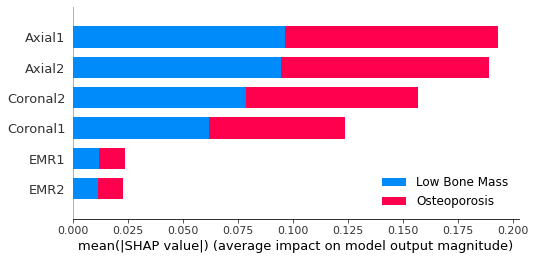

In [178]:
import shap

dct = pkl.load(open('Models/Fusion/test_predictions.pkl', 'rb'))
labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

names = ['Coronal1', 'Coronal2','Axial1', 'Axial2',  'EMR1', 'EMR2']
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(mat_test)

shap.summary_plot(shap_values, mat_test, feature_names = names, class_names = ['Low Bone Mass', 'Osteoporosis'],  show=False)
plt.savefig('Figures/shap_plot_fusion.jpg', bbox_inches='tight')

In [187]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('Models/Fusion/test_predictions.pkl', 'rb'))
y_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])




    
target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx,1]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

MCHS
Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[84.6-93.1]
Recall
[87.3-94.7]
F-score
[85.5-93.6]
AUC-ROC
[87.5-96.3]


In [66]:
for gender in ['F', 'M']:
    print(gender)
    gender_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]==gender])
    print(classification_report(labels_test[gender_idx], preds[gender_idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[gender_idx], probs[gender_idx,1]))
    cm = confusion_matrix(labels_test[gender_idx], preds[gender_idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

FEMALE
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       359
         1.0       0.80      0.82      0.81       426

    accuracy                           0.79       785
   macro avg       0.79      0.79      0.79       785
weighted avg       0.79      0.79      0.79       785

AUC-ROC:	 0.8545124040435744
Confusion Matrix:
 [[272  87]
 [ 77 349]]
MALE
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       311
         1.0       0.60      0.65      0.62       109

    accuracy                           0.80       420
   macro avg       0.74      0.75      0.74       420
weighted avg       0.80      0.80      0.80       420

AUC-ROC:	 0.8554824626095165
Confusion Matrix:
 [[263  48]
 [ 38  71]]


In [67]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        85
         1.0       0.85      0.73      0.78        70

    accuracy                           0.82       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.82      0.82      0.82       155

AUC-ROC:	 0.9117647058823529
Confusion Matrix:
 [[76  9]
 [19 51]]
SIEMENS
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       561
         1.0       0.74      0.79      0.76       442

    accuracy                           0.78      1003
   macro avg       0.78      0.78      0.78      1003
weighted avg       0.79      0.78      0.78      1003

AUC-ROC:	 0.8616098434437534
Confusion Matrix:
 [[437 124]
 [ 93 349]]
TOSHIBA
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        24
         1.0       0.91      0.87      0.89        23

    accuracy             

In [68]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.65        56
         1.0       0.83      0.86      0.85       123

    accuracy                           0.79       179
   macro avg       0.75      0.74      0.75       179
weighted avg       0.78      0.79      0.79       179

AUC-ROC:	 0.8244047619047618
Confusion Matrix:
 [[ 35  21]
 [ 17 106]]
250-350
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       472
         1.0       0.76      0.78      0.77       380

    accuracy                           0.79       852
   macro avg       0.79      0.79      0.79       852
weighted avg       0.79      0.79      0.79       852

AUC-ROC:	 0.8687946030330063
Confusion Matrix:
 [[376  96]
 [ 84 296]]
350-1000
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       142
         1.0       0.50      0.56      0.53        32

    accuracy     

In [183]:
companies = ['MN', 'FL', 'AZ', 'MCHS']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c == df_test.facility.values[i]])
    #print(idx)
    print(classification_report(labels_test[idx], preds[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

MN
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       234
         1.0       0.75      0.84      0.79       221

    accuracy                           0.78       455
   macro avg       0.79      0.79      0.78       455
weighted avg       0.79      0.78      0.78       455

AUC-ROC:	 0.8713887922032719
Confusion Matrix:
 [[172  62]
 [ 36 185]]
FL
              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       199
         1.0       0.65      0.78      0.71       111

    accuracy                           0.77       310
   macro avg       0.76      0.78      0.76       310
weighted avg       0.79      0.77      0.78       310

AUC-ROC:	 0.838697994476889
Confusion Matrix:
 [[153  46]
 [ 24  87]]
AZ
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       179
         1.0       0.81      0.75      0.78       170

    accuracy                    

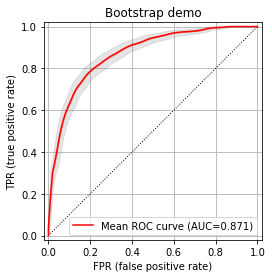

In [131]:
dct = pkl.load(open('Models/Fusion/test_predictions.pkl', 'rb')) #late fusion

y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])

rocs = compute_roc_bootstrap(X=probs[:,1], y=y_test, pos_label=1.0,#[:,1]
                             n_bootstrap=1000,
                             random_state=42,
                             return_mean=False)

plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("Bootstrap demo");
plt.savefig('Figures/fusion_mean_roc.jpg')
plt.show()

minopt:         thr= 0.533, J= -0.289


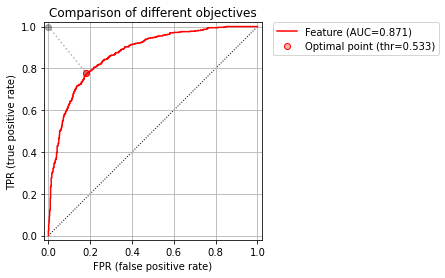

In [132]:
dct = pkl.load(open('Models/Fusion/test_predictions.pkl', 'rb')) #late fusion
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])

roc = compute_roc(X=probs[:,1], y=y_test, pos_label=1.0,
                  objective=["minopt"
                            ])
for key, val in roc.opd.items():
    print("%-15s thr=% .3f, J=%7.3f" % (key+":", val.opt, val.opo) )
    
plot_roc(roc, show_opt=True)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("Comparison of different objectives");
plt.savefig('Figures/fusion_roc_op.jpg', bbox_inches='tight')

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


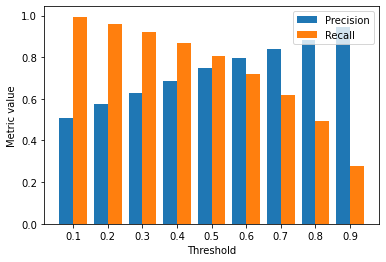

In [138]:
from sklearn.metrics import precision_score, recall_score
# Note that multiple objective functions can be computed at the same time.

dct = pkl.load(open('Models/Fusion/test_predictions.pkl', 'rb')) #late fusion
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'][:, 1])

precision = []
recall = []
th_list =  [0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for th in th_list:
    preds = np.array([1 if p>th else 0 for p in probs])
    precision.append(precision_score(y_test, preds))
    recall.append(recall_score(y_test, preds))
    print(th)

X_axis = np.arange(9)
plt.bar(X_axis - 0.2, precision, 0.4, label = 'Precision')
plt.bar(X_axis + 0.2, recall, 0.4, label = 'Recall')
  
plt.xticks(X_axis, th_list)
plt.ylabel("Metric value")
plt.xlabel("Threshold")

plt.legend(loc = 'upper right')

plt.savefig('Figures/late_fusion_PR.jpg', bbox_inches='tight')


